## Heritage from Level 1B)
* 1 building - site 1241
* 1 meter reading - meter 0
* air_temperature

In [ ]:
level_1b = {'building_id': 1241, 'meter': 0}
level_1b_cols = ['meter_reading', 'timestamp', 'air_temperature']

In [ ]:
data_1b = data_subset_by_dict(train_data, level_1b, level_1b_cols)

In [ ]:
plt.figure(figsize=(10,10))
plt.ylabel('Electricity read')
plt.xlabel('Air Temperature')
d_pre_nov = data_1b[data_1b.timestamp < datetime(year=2016, month=11, day=10)]
d_post_nov = data_1b[data_1b.timestamp > datetime(year=2016, month=11, day=10)]
plt.scatter(d_pre_nov.air_temperature, d_pre_nov.meter_reading, alpha=0.3, label='Pre-missing')
plt.scatter(d_post_nov.air_temperature, d_post_nov.meter_reading, alpha=0.3, label='Post-missing')
plt.legend()
plt.xlim(-25,40)
plt.show()

We can see that the measurment pre and post the missing period was very different.
What I suspect is that the old meter had less precision (from there the bands), then it broke and the new meter has way more precision (from here the more distributed)

## Weather EDA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tsm.data_selector import data_subset_by_dict
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_data = pd.read_pickle('kaggle/input/ashrae-energy-prediction/train.pkl')

In [5]:
# We need to know if there is 'timestamp' in test data, to know if we can use autoregressive stuff
test_data = pd.read_pickle('kaggle/input/ashrae-energy-prediction/test.pkl')

In [8]:
'timestamp' in list(test_data)

True

In [10]:
del test_data

Need to see which buildings are in which sites, because for this notebook I want to take a single site

In [17]:
builds_sites = set(list(zip(train_data.building_id.values, train_data.site_id.values)))

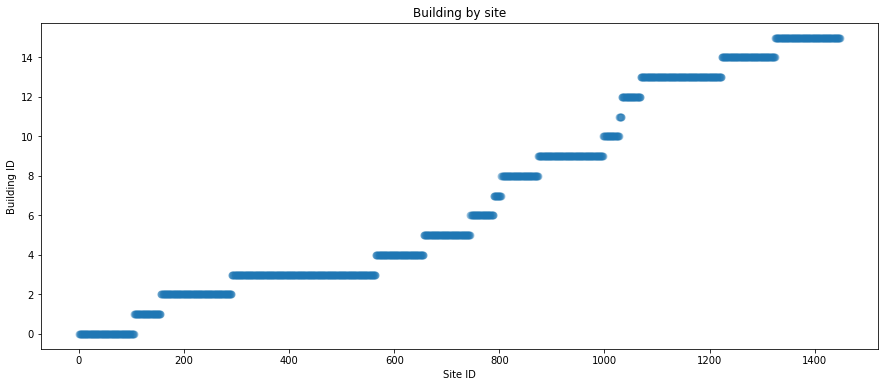

In [34]:
plt.figure(figsize=(15,6))
plt.title('Building by site')
plt.xlabel('Site ID')
plt.ylabel('Building ID')
plt.scatter([x[0] for x in builds_sites], [x[1] for x in builds_sites], alpha=0.3, s=50)
plt.show()

Also I saw from before that buildings in the 1200+ regions tends to have all meter types.
Thus I will take site ID 14.

In [36]:
len([x for x in builds_sites if x[1] == 15])

124

## Level 2A)
* 1 site - 124 buildings
* 1 meter reading - meter 0
* Weather data

In [41]:
level_2a = {'site_id': 14, 'meter': 0}
level_2a_cols = ['building_id', 'meter_reading', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed',]

In [42]:
data_2a = data_subset_by_dict(train_data, level_2a, level_2a_cols)

In [43]:
data_2a.head()

,building_id,meter_reading,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1778,1223,79.845299,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
1781,1224,12.000000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
1784,1225,185.647003,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
1787,1226,42.340900,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
1790,1227,52.820000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0


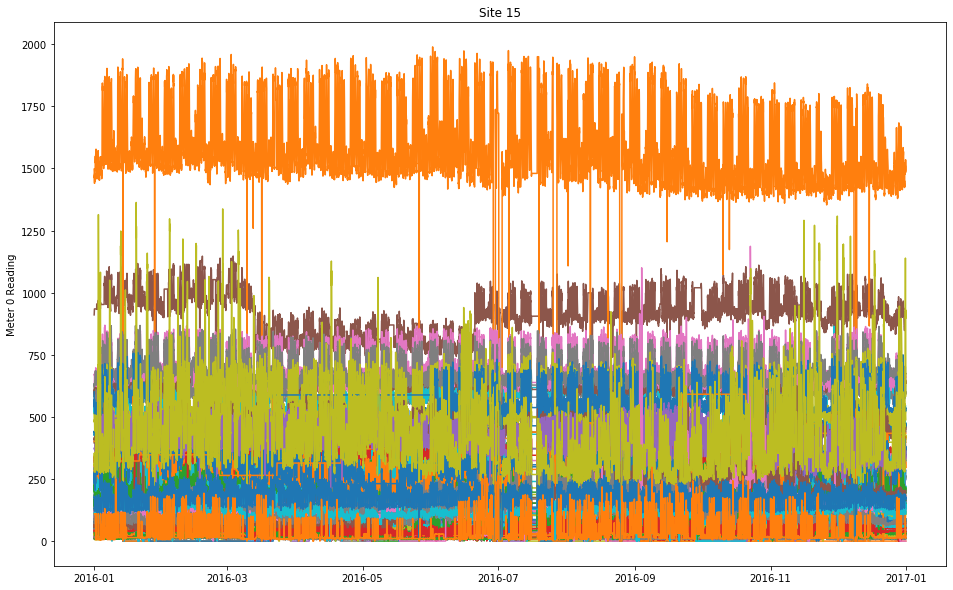

In [45]:
plt.figure(figsize=(16,10))
plt.title('Site 15')
plt.ylabel('Meter 0 Reading')
for build in set(data_2a.building_id):
    build_data = data_2a[data_2a.building_id == build]
    plt.plot(build_data.timestamp, build_data.meter_reading)
plt.show()

In [47]:
data_2a.corr()['meter_reading']

building_id           0.112914
meter_reading         1.000000
air_temperature       0.010153
cloud_coverage        0.004978
dew_temperature      -0.008586
precip_depth_1_hr    -0.009011
sea_level_pressure   -0.001474
wind_direction        0.014874
wind_speed            0.011439
Name: meter_reading, dtype: float64

Correlations do not seem that strong. Could it be a matter of different buildings?

In [48]:
build_series = []
for build in set(data_2a.building_id):
    build_data = data_2a[data_2a.building_id == build]
    series = build_data.corr()['meter_reading']
    series.name = build
    build_series.append(series)

In [53]:
# Max correlation by building
pd.concat(build_series, axis=1).max(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature       0.692897
cloud_coverage        0.146216
dew_temperature       0.595458
precip_depth_1_hr     0.034446
sea_level_pressure    0.040068
wind_direction        0.147866
wind_speed            0.117493
dtype: float64

We can see that:
* Air temperature have a correlation of 0.7 in one case
* Dew temperature of 0.6
* Precip_depth_1_hr and sea_level_pressure seem irrelevant for electricity
* Cloud_coverage, Wind_direction, wind_speed have low max correlations

Let me start just with air_temperature and dew_temperature

In [66]:
from tsm.data_utils import train_dev_test_split, get_data_sample, df_to_x_y

In [61]:
data_2a_1 = data_2a[['building_id', 'meter_reading', 'air_temperature', 'dew_temperature']]

In [68]:
data_2a1_tr, data_2a1_ts = train_dev_test_split(data_2a_1, train_pct=0.75, dev_pct=0)

In [69]:
_2a1_dx = [0, 2, 3]
_2a1_dy = 1

In [70]:
_2a1_tr_x, _2a1_tr_y = df_to_x_y(data_2a1_tr, _2a1_dx, _2a1_dy)
_2a1_ts_x, _2a1_ts_y = df_to_x_y(data_2a1_ts, _2a1_dx, _2a1_dy)

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
from tsm.eval_metrics import root_mean_squared_log_error

In [72]:
rfr = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=39)

In [73]:
rfr.fit(_2a1_tr_x, _2a1_tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [75]:
root_mean_squared_log_error(rfr.predict(_2a1_ts_x), _2a1_ts_y)

1.406493593074633

Now let me measure the above with few lags of both 'air_temperature', 'dew_temperature'

In [76]:
from tsm.data_selector import get_series_past_k_lags

In [102]:
for k in [48 * 2, 48 * 4]:
    k_air = get_series_past_k_lags(data_2a_1['air_temperature'], k=3).fillna(99).reset_index(drop=True)
    k_dew = get_series_past_k_lags(data_2a_1['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
    data_2a2 = pd.concat([data_2a_1.reset_index(drop=True), k_air, k_dew], axis=1, sort=False)
    data_2a2_tr, data_2a2_ts = train_dev_test_split(data_2a2, train_pct=0.75, dev_pct=0)
    data_2a2_tr
    _2a2_dx = [0] + [x for x in range(2, len(list(data_2a2_tr)))]
    _2a2_dy = 1
    _2a2_tr_x, _2a2_tr_y = df_to_x_y(data_2a2_tr, _2a2_dx, _2a2_dy)
    _2a2_ts_x, _2a2_ts_y = df_to_x_y(data_2a2_ts, _2a2_dx, _2a2_dy)
    rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
    rfr.fit(_2a2_tr_x, _2a2_tr_y)
    rmsle = root_mean_squared_log_error(rfr.predict(_2a2_ts_x), _2a2_ts_y)
    print(f'RMSLE with {k} air and dew regressors', rmsle)

RMSLE with 96 air and dew regressors 1.4193589499158987
RMSLE with 192 air and dew regressors 1.4191412622495965


### Same values as above without 0s

In [105]:
log_2a1_mr = np.log(data_2a_1.meter_reading)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [112]:
log_2a1_mr = log_2a1_mr[log_2a1_mr > 0]
log_2a1_mr.name = 'log_meter_reading'

In [114]:
data_2a_3 = pd.concat([data_2a_1, log_2a1_mr], axis=1).dropna()

In [115]:
data_2a_3.drop('meter_reading', axis=1, inplace=True)

In [120]:
for k in [0, 3, 6, 12, 24]:
    if k > 0:
        k_air = get_series_past_k_lags(data_2a_3['air_temperature'], k=3).fillna(99).reset_index(drop=True)
        k_dew = get_series_past_k_lags(data_2a_3['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
        data_2a3 = pd.concat([data_2a_3.reset_index(drop=True), k_air, k_dew], axis=1, sort=False)
    else:
        data_2a3 = data_2a_3
    data_2a3_tr, data_2a3_ts = train_dev_test_split(data_2a3, train_pct=0.75, dev_pct=0)
    _2a3_dx = [x for x in range(0, len(list(data_2a3_tr)) - 1)]
    _2a3_dy = -1
    _2a3_tr_x, _2a3_tr_y = df_to_x_y(data_2a3_tr, _2a3_dx, _2a3_dy)
    _2a3_ts_x, _2a3_ts_y = df_to_x_y(data_2a3_ts, _2a3_dx, _2a3_dy)
    rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
    rfr.fit(_2a3_tr_x, _2a3_tr_y)
    rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a3_ts_x)), np.exp(_2a3_ts_y))
    print(f'RMSLE with {k} air and dew regressors', rmsle)

RMSLE with 0 air and dew regressors 0.3706585178515587
RMSLE with 3 air and dew regressors 0.08194362413850254
RMSLE with 6 air and dew regressors 0.08195113680378277
RMSLE with 12 air and dew regressors 0.08110594630881172
RMSLE with 24 air and dew regressors 0.08109768919533313


In [129]:
# Pct of data removed
print(round((len(data_2a_2) - len(data_2a_3)) / len(data_2a_2) * 100, 2),'%')

4.56 %


### Same values as above with all weather features

In [134]:
data_2a3_tr, data_2a3_ts = train_dev_test_split(data_2a, train_pct=0.75, dev_pct=0)
data_2a3_tr
_2a3_dx = [0] + [x for x in range(3, len(list(data_2a)))]
_2a3_dy = 1
_2a3_tr_x, _2a3_tr_y = df_to_x_y(data_2a3_tr, _2a3_dx, _2a3_dy)
_2a3_ts_x, _2a3_ts_y = df_to_x_y(data_2a3_ts, _2a3_dx, _2a3_dy)
rfr = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=39)
rfr.fit(_2a3_tr_x, _2a3_tr_y)
rmsle = root_mean_squared_log_error(rfr.predict(_2a3_ts_x), _2a3_ts_y)
print(f'RMSLE with all weather', rmsle)

RMSLE with all weather 1.4076082125248512


In [140]:
log_2a4_mr = np.log(data_2a.meter_reading)
log_2a4_mr = log_2a4_mr[log_2a4_mr > 0]
log_2a4_mr.name = 'log_meter_reading'
data_2a_4 = pd.concat([data_2a, log_2a4_mr], axis=1).dropna()
data_2a_4.drop('meter_reading', axis=1, inplace=True)
data_2a4_tr, data_2a4_ts = train_dev_test_split(data_2a_4, train_pct=0.75, dev_pct=0)
_2a4_dx = [0] + [x for x in range(2, len(list(data_2a4_tr)) - 1)]
_2a4_dy = -1
_2a4_tr_x, _2a4_tr_y = df_to_x_y(data_2a4_tr, _2a4_dx, _2a4_dy)
_2a4_ts_x, _2a4_ts_y = df_to_x_y(data_2a4_ts, _2a4_dx, _2a4_dy)
rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
rfr.fit(_2a4_tr_x, _2a4_tr_y)
rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a4_ts_x)), np.exp(_2a4_ts_y))
print(f'RMSLE with all weather', rmsle)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


RMSLE with all weather 0.35866412056520464


In [148]:
log_2a5_mr = np.log(data_2a.meter_reading)
log_2a5_mr = log_2a5_mr[log_2a5_mr > 0]
log_2a5_mr.name = 'log_meter_reading'
data_2a_5 = pd.concat([data_2a, log_2a5_mr], axis=1).dropna()
data_2a_5.drop('meter_reading', axis=1, inplace=True)
k_air = get_series_past_k_lags(data_2a_5['air_temperature'], k=3).fillna(99).reset_index(drop=True)
k_dew = get_series_past_k_lags(data_2a_5['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
data_2a5 = pd.concat([data_2a_5.reset_index(drop=True), k_air, k_dew], axis=1, sort=False) 
data_2a5_tr, data_2a5_ts = train_dev_test_split(data_2a5, train_pct=0.75, dev_pct=0)
data_2a5_tr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,building_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,air_temperature_t-1,air_temperature_t-2,air_temperature_t-3,dew_temperature_t-1,dew_temperature_t-2,dew_temperature_t-3
0,1223,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,4.380091,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
1,1224,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,2.484907,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
2,1225,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,5.223847,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
3,1226,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,3.745754,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
4,1227,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,3.966890,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
5,1228,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,4.840796,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
6,1229,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,2.678278,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
7,1230,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,3.178054,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
8,1231,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,2.379546,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
9,1232,2016-01-01 00:00:00,99.000000,99,99.000000,999,9999.000000,999,99.0,5.356530,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000


In [151]:
_2a5_dy = len(list(data_2a_5)) -1
_2a5_dx = [0] + [x for x in range(2, len(list(data_2a5_tr)) - 1) if x != _2a5_dy]
_2a5_dy, _2a5_dx

(9, [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14])

In [154]:
_2a5_tr_x, _2a5_tr_y = df_to_x_y(data_2a5_tr, _2a5_dx, _2a5_dy)
_2a5_ts_x, _2a5_ts_y = df_to_x_y(data_2a5_ts, _2a5_dx, _2a5_dy)
rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
rfr.fit(_2a5_tr_x, _2a5_tr_y)
rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a5_ts_x)), np.exp(_2a5_ts_y))
print(f'RMSLE with all weather', rmsle)

RMSLE with all weather 0.0772596366782906


## Level 2A) Repeat!
* 1 site - 91 buildings
* 1 meter reading - meter 0
* Weather data

In [156]:
len([x for x in builds_sites if x[1] == 4])

91

In [157]:
level_2a = {'site_id': 4, 'meter': 0}
level_2a_cols = ['building_id', 'meter_reading', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed',]

In [158]:
data_2a = data_subset_by_dict(train_data, level_2a, level_2a_cols)

In [159]:
data_2a.head()

,building_id,meter_reading,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
722,565,7.250000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
723,566,0.519000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
724,569,246.000000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
725,570,79.487999,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0
726,571,17.000000,2016-01-01,99.0,99,99.0,999,9999.0,999,99.0


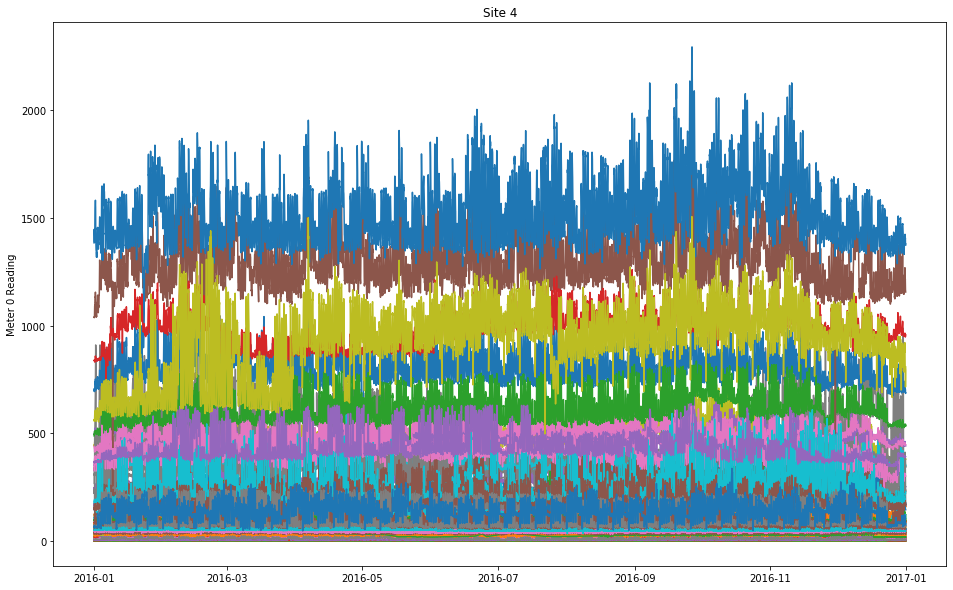

In [161]:
plt.figure(figsize=(16,10))
plt.title('Site 4')
plt.ylabel('Meter 0 Reading')
for build in set(data_2a.building_id):
    build_data = data_2a[data_2a.building_id == build]
    plt.plot(build_data.timestamp, build_data.meter_reading)
plt.show()

In [162]:
data_2a.corr()['meter_reading']

building_id           0.195795
meter_reading         1.000000
air_temperature      -0.014242
cloud_coverage        0.007398
dew_temperature       0.004928
precip_depth_1_hr     0.007528
sea_level_pressure    0.001357
wind_direction       -0.015871
wind_speed           -0.026721
Name: meter_reading, dtype: float64

Correlations do not seem that strong. Could it be a matter of different buildings?

In [163]:
build_series = []
for build in set(data_2a.building_id):
    build_data = data_2a[data_2a.building_id == build]
    series = build_data.corr()['meter_reading']
    series.name = build
    build_series.append(series)

In [165]:
# Max correlation by building
pd.concat(build_series, axis=1).max(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature       0.423224
cloud_coverage        0.177722
dew_temperature       0.361029
precip_depth_1_hr     0.198162
sea_level_pressure    0.060013
wind_direction        0.140097
wind_speed            0.135956
dtype: float64

Similar trends hold in max correlation

Let me start just with air_temperature and dew_temperature

In [166]:
from tsm.data_utils import train_dev_test_split, get_data_sample, df_to_x_y

In [167]:
data_2a_1 = data_2a[['building_id', 'meter_reading', 'air_temperature', 'dew_temperature']]

In [168]:
data_2a1_tr, data_2a1_ts = train_dev_test_split(data_2a_1, train_pct=0.75, dev_pct=0)

In [169]:
_2a1_dx = [0, 2, 3]
_2a1_dy = 1

In [170]:
_2a1_tr_x, _2a1_tr_y = df_to_x_y(data_2a1_tr, _2a1_dx, _2a1_dy)
_2a1_ts_x, _2a1_ts_y = df_to_x_y(data_2a1_ts, _2a1_dx, _2a1_dy)

In [171]:
from sklearn.ensemble import RandomForestRegressor

In [172]:
from tsm.eval_metrics import root_mean_squared_log_error

In [175]:
rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)

In [176]:
rfr.fit(_2a1_tr_x, _2a1_tr_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [177]:
root_mean_squared_log_error(rfr.predict(_2a1_ts_x), _2a1_ts_y)

0.8615170635341355

Now let me measure the above with few lags of both 'air_temperature', 'dew_temperature'

In [179]:
for k in [3, 6, 12, 24, 48]:
    k_air = get_series_past_k_lags(data_2a_1['air_temperature'], k=3).fillna(99).reset_index(drop=True)
    k_dew = get_series_past_k_lags(data_2a_1['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
    data_2a2 = pd.concat([data_2a_1.reset_index(drop=True), k_air, k_dew], axis=1, sort=False)
    data_2a2_tr, data_2a2_ts = train_dev_test_split(data_2a2, train_pct=0.75, dev_pct=0)
    data_2a2_tr
    _2a2_dx = [0] + [x for x in range(2, len(list(data_2a2_tr)))]
    _2a2_dy = 1
    _2a2_tr_x, _2a2_tr_y = df_to_x_y(data_2a2_tr, _2a2_dx, _2a2_dy)
    _2a2_ts_x, _2a2_ts_y = df_to_x_y(data_2a2_ts, _2a2_dx, _2a2_dy)
    rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
    rfr.fit(_2a2_tr_x, _2a2_tr_y)
    rmsle = root_mean_squared_log_error(rfr.predict(_2a2_ts_x), _2a2_ts_y)
    print(f'RMSLE with {k} air and dew regressors', rmsle)

RMSLE with 3 air and dew regressors 0.8608753872472646
RMSLE with 6 air and dew regressors 0.8624925372923419
RMSLE with 12 air and dew regressors 0.852026272661169
RMSLE with 24 air and dew regressors 0.8602766260850627
RMSLE with 48 air and dew regressors 0.8293256061716616


### Same values as above without 0s

In [180]:
log_2a1_mr = np.log(data_2a_1.meter_reading)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [181]:
log_2a1_mr = log_2a1_mr[log_2a1_mr > 0]
log_2a1_mr.name = 'log_meter_reading'

In [182]:
data_2a_3 = pd.concat([data_2a_1, log_2a1_mr], axis=1).dropna()

In [183]:
data_2a_3.drop('meter_reading', axis=1, inplace=True)

In [184]:
for k in [0, 3, 6, 12, 24]:
    if k > 0:
        k_air = get_series_past_k_lags(data_2a_3['air_temperature'], k=3).fillna(99).reset_index(drop=True)
        k_dew = get_series_past_k_lags(data_2a_3['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
        data_2a3 = pd.concat([data_2a_3.reset_index(drop=True), k_air, k_dew], axis=1, sort=False)
    else:
        data_2a3 = data_2a_3
    data_2a3_tr, data_2a3_ts = train_dev_test_split(data_2a3, train_pct=0.75, dev_pct=0)
    _2a3_dx = [x for x in range(0, len(list(data_2a3_tr)) - 1)]
    _2a3_dy = -1
    _2a3_tr_x, _2a3_tr_y = df_to_x_y(data_2a3_tr, _2a3_dx, _2a3_dy)
    _2a3_ts_x, _2a3_ts_y = df_to_x_y(data_2a3_ts, _2a3_dx, _2a3_dy)
    rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
    rfr.fit(_2a3_tr_x, _2a3_tr_y)
    rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a3_ts_x)), np.exp(_2a3_ts_y))
    print(f'RMSLE with {k} air and dew regressors', rmsle)

RMSLE with 0 air and dew regressors 0.5254433226126606
RMSLE with 3 air and dew regressors 0.16877105627353586
RMSLE with 6 air and dew regressors 0.14482737454467784
RMSLE with 12 air and dew regressors 0.1606809089411141
RMSLE with 24 air and dew regressors 0.15583296579941977


In [185]:
# Pct of data removed
print(round((len(data_2a_2) - len(data_2a_3)) / len(data_2a_2) * 100, 2),'%')

21.6 %


### Same values as above with all weather features

In [186]:
data_2a3_tr, data_2a3_ts = train_dev_test_split(data_2a, train_pct=0.75, dev_pct=0)
data_2a3_tr
_2a3_dx = [0] + [x for x in range(3, len(list(data_2a)))]
_2a3_dy = 1
_2a3_tr_x, _2a3_tr_y = df_to_x_y(data_2a3_tr, _2a3_dx, _2a3_dy)
_2a3_ts_x, _2a3_ts_y = df_to_x_y(data_2a3_ts, _2a3_dx, _2a3_dy)
rfr = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=39)
rfr.fit(_2a3_tr_x, _2a3_tr_y)
rmsle = root_mean_squared_log_error(rfr.predict(_2a3_ts_x), _2a3_ts_y)
print(f'RMSLE with all weather', rmsle)

RMSLE with all weather 0.3838158449428987


In [187]:
log_2a4_mr = np.log(data_2a.meter_reading)
log_2a4_mr = log_2a4_mr[log_2a4_mr > 0]
log_2a4_mr.name = 'log_meter_reading'
data_2a_4 = pd.concat([data_2a, log_2a4_mr], axis=1).dropna()
data_2a_4.drop('meter_reading', axis=1, inplace=True)
data_2a4_tr, data_2a4_ts = train_dev_test_split(data_2a_4, train_pct=0.75, dev_pct=0)
_2a4_dx = [0] + [x for x in range(2, len(list(data_2a4_tr)) - 1)]
_2a4_dy = -1
_2a4_tr_x, _2a4_tr_y = df_to_x_y(data_2a4_tr, _2a4_dx, _2a4_dy)
_2a4_ts_x, _2a4_ts_y = df_to_x_y(data_2a4_ts, _2a4_dx, _2a4_dy)
rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
rfr.fit(_2a4_tr_x, _2a4_tr_y)
rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a4_ts_x)), np.exp(_2a4_ts_y))
print(f'RMSLE with all weather', rmsle)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


RMSLE with all weather 0.5419623692419208


In [188]:
log_2a5_mr = np.log(data_2a.meter_reading)
log_2a5_mr = log_2a5_mr[log_2a5_mr > 0]
log_2a5_mr.name = 'log_meter_reading'
data_2a_5 = pd.concat([data_2a, log_2a5_mr], axis=1).dropna()
data_2a_5.drop('meter_reading', axis=1, inplace=True)
k_air = get_series_past_k_lags(data_2a_5['air_temperature'], k=3).fillna(99).reset_index(drop=True)
k_dew = get_series_past_k_lags(data_2a_5['dew_temperature'], k=3).fillna(99).reset_index(drop=True)
data_2a5 = pd.concat([data_2a_5.reset_index(drop=True), k_air, k_dew], axis=1, sort=False) 
data_2a5_tr, data_2a5_ts = train_dev_test_split(data_2a5, train_pct=0.75, dev_pct=0)
data_2a5_tr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,building_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,air_temperature_t-1,air_temperature_t-2,air_temperature_t-3,dew_temperature_t-1,dew_temperature_t-2,dew_temperature_t-3
0,565,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,1.981001,99.0,99.0,99.0,99.0,99.0,99.0
1,569,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,5.505332,99.0,99.0,99.0,99.0,99.0,99.0
2,570,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,4.375606,99.0,99.0,99.0,99.0,99.0,99.0
3,571,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,2.833213,99.0,99.0,99.0,99.0,99.0,99.0
4,572,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,5.738747,99.0,99.0,99.0,99.0,99.0,99.0
5,573,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,2.184117,99.0,99.0,99.0,99.0,99.0,99.0
6,574,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,3.047494,99.0,99.0,99.0,99.0,99.0,99.0
7,575,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,3.116843,99.0,99.0,99.0,99.0,99.0,99.0
8,576,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,4.764308,99.0,99.0,99.0,99.0,99.0,99.0
9,577,2016-01-01 00:00:00,99.0,99,99.0,999,9999.000000,999,99.0,3.797734,99.0,99.0,99.0,99.0,99.0,99.0


In [189]:
_2a5_dy = len(list(data_2a_5)) -1
_2a5_dx = [0] + [x for x in range(2, len(list(data_2a5_tr)) - 1) if x != _2a5_dy]
_2a5_dy, _2a5_dx

(9, [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14])

In [191]:
_2a5_tr_x, _2a5_tr_y = df_to_x_y(data_2a5_tr, _2a5_dx, _2a5_dy)
_2a5_ts_x, _2a5_ts_y = df_to_x_y(data_2a5_ts, _2a5_dx, _2a5_dy)
rfr = RandomForestRegressor(max_depth=10, n_jobs=-1, n_estimators=11)
rfr.fit(_2a5_tr_x, _2a5_tr_y)
rmsle = root_mean_squared_log_error(np.exp(rfr.predict(_2a5_ts_x)), np.exp(_2a5_ts_y))
print(f'RMSLE with all weather', rmsle)

RMSLE with all weather 0.5178904083400755


## Level 2B)
* 1 site
* 1 meter reading - meter 1
* Weather data

In [4]:
level_2b = {'site_id': 2, 'meter': 1}
level_2b_cols = ['building_id', 'meter_reading', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed',]

In [5]:
data_2b = data_subset_by_dict(train_data, level_2b, level_2b_cols)

In [6]:
data_2b.head()

,building_id,meter_reading,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
172,161,0.000000,2016-01-01,15.6,6,-5.6,999,1015.299988,270,3.6
174,162,0.000000,2016-01-01,15.6,6,-5.6,999,1015.299988,270,3.6
176,163,4.571900,2016-01-01,15.6,6,-5.6,999,1015.299988,270,3.6
181,166,209.886002,2016-01-01,15.6,6,-5.6,999,1015.299988,270,3.6
184,167,0.000000,2016-01-01,15.6,6,-5.6,999,1015.299988,270,3.6


In [7]:
# How many buildings?
len(set(data_2b.building_id))

99

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


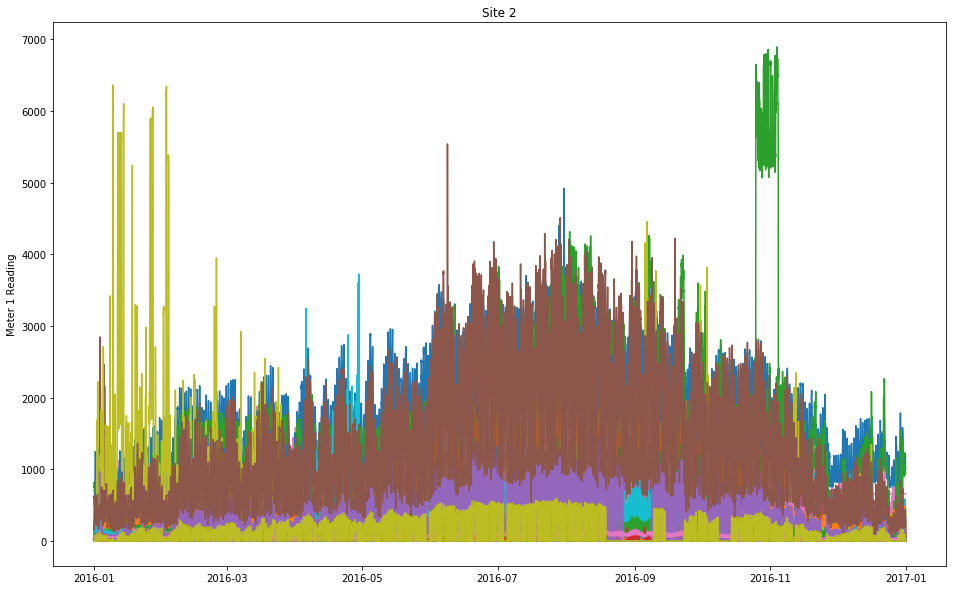

In [9]:
plt.figure(figsize=(16,10))
plt.title('Site 2')
plt.ylabel('Meter 1 Reading')
for build in set(data_2b.building_id):
    build_data = data_2b[data_2b.building_id == build]
    plt.plot(build_data.timestamp, build_data.meter_reading)
plt.show()

In [10]:
data_2b.corr()['meter_reading']

building_id          -0.067861
meter_reading         1.000000
air_temperature       0.205179
cloud_coverage       -0.008908
dew_temperature       0.199903
precip_depth_1_hr    -0.012281
sea_level_pressure   -0.010417
wind_direction        0.011135
wind_speed            0.021136
Name: meter_reading, dtype: float64

In [11]:
build_series = []
for build in set(data_2b.building_id):
    build_data = data_2b[data_2b.building_id == build]
    series = build_data.corr()['meter_reading']
    series.name = build
    build_series.append(series)

In [12]:
# Max correlation by building
pd.concat(build_series, axis=1).max(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature       0.795656
cloud_coverage        0.081954
dew_temperature       0.763160
precip_depth_1_hr     0.095031
sea_level_pressure    0.035345
wind_direction        0.121586
wind_speed            0.123699
dtype: float64

Values are very similar with meter 0, perhaps same approach should be used?

## Level 2C)
* 1 site
* 1 meter reading - meter 2
* Weather data

In [17]:
level_2c = {'site_id': 9, 'meter': 2}
level_2c_cols = ['building_id', 'meter_reading', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed',]

In [18]:
data_2c = data_subset_by_dict(train_data, level_2c, level_2c_cols)

In [19]:
# How many buildings?
len(set(data_2c.building_id))

89

In [20]:
data_2c.corr()['meter_reading']

building_id           0.062341
meter_reading         1.000000
air_temperature      -0.219779
cloud_coverage       -0.003914
dew_temperature      -0.216073
precip_depth_1_hr     0.014002
sea_level_pressure   -0.006630
wind_direction       -0.039878
wind_speed           -0.007115
Name: meter_reading, dtype: float64

In [21]:
build_series = []
for build in set(data_2c.building_id):
    build_data = data_2c[data_2c.building_id == build]
    series = build_data.corr()['meter_reading']
    series.name = build
    build_series.append(series)

In [24]:
# Max correlation by building
pd.concat(build_series, axis=1).min(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature      -0.771857
cloud_coverage       -0.076895
dew_temperature      -0.725396
precip_depth_1_hr    -0.013080
sea_level_pressure   -0.033167
wind_direction       -0.146084
wind_speed           -0.038329
dtype: float64

In [25]:
# Max correlation by building
pd.concat(build_series, axis=1).max(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature      -0.048964
cloud_coverage        0.134101
dew_temperature       0.044905
precip_depth_1_hr     0.059978
sea_level_pressure    0.042321
wind_direction       -0.001968
wind_speed            0.034642
dtype: float64

Also similar results but with negative values :)

## Level 2D)
* 1 site
* 1 meter reading - meter 3
* Weather data

In [29]:
level_2d = {'site_id': 14, 'meter': 3}
level_2d_cols = ['building_id', 'meter_reading', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed',]

In [30]:
data_2d = data_subset_by_dict(train_data, level_2d, level_2d_cols)

In [31]:
# How many buildings?
len(set(data_2d.building_id))

57

In [32]:
data_2d.corr()['meter_reading']

building_id           0.059089
meter_reading         1.000000
air_temperature      -0.305626
cloud_coverage        0.017176
dew_temperature      -0.295450
precip_depth_1_hr     0.002474
sea_level_pressure   -0.008066
wind_direction       -0.005647
wind_speed            0.001880
Name: meter_reading, dtype: float64

In [33]:
build_series = []
for build in set(data_2d.building_id):
    build_data = data_2d[data_2d.building_id == build]
    series = build_data.corr()['meter_reading']
    series.name = build
    build_series.append(series)

In [34]:
# Min correlation by building
pd.concat(build_series, axis=1).min(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature      -0.787877
cloud_coverage       -0.079564
dew_temperature      -0.748949
precip_depth_1_hr    -0.022170
sea_level_pressure   -0.036754
wind_direction       -0.124649
wind_speed           -0.057820
dtype: float64

In [35]:
# Max correlation by building
pd.concat(build_series, axis=1).max(axis=1)

building_id                NaN
meter_reading         1.000000
air_temperature       0.553056
cloud_coverage        0.125157
dew_temperature       0.542336
precip_depth_1_hr     0.028436
sea_level_pressure    0.026319
wind_direction        0.076814
wind_speed            0.058470
dtype: float64

Also similar results.